In [132]:
%matplotlib inline
#from __future__ import division, print_function
#import sys
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
#from astropy.coordinates import SkyCoord
from matplotlib.ticker import NullFormatter
#from astropy import units as u
import fitsio
import pandas as pd
from astropy.io import ascii
#from astropy.coordinates import SkyCoord
import sys, os, time, argparse, glob
#import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')
from astropy.utils.data import download_file  #import file from URL

#from desitarget.targetmask import desi_mask
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
import random

from kdcount import KDTree
from veto import veto, veto_ellip, match

from match_coord import search_around, scatter_plot, match_coord
import healpy as hp
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from astropy import units as u

#from pyvenn import venn
#from matplotlib_chord_diagram import matplotlib_chord

from desitarget.targetmask import desi_mask, bgs_mask
from main_def import cut_sweeps, cut, load_cat_caseA, load_cat_caseA_SV, load_cat_caseB, load_cat_caseC, load_cat_caseD, get_mag_decals, MASK, unextinct_fluxes, flux_to_mag, matrix_plot, bar_plot, venn_plot, target_con

In [160]:
!pwd

/global/project/projectdirs/desi/users/qmxp55/matches


In [159]:
#from mpl_toolkits.basemap import pyproj
!cp -r /global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/mpl_toolkits/ .
#!cp /global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/code/desimodel/0.9.4/data/footprint/desi-healpix-weights.fits .

In [147]:
from desiutil.log import get_logger
!cp /global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/code/desiutil/1.9.10/lib/python3.6/site-packages/desiutil-1.9.10-py3.6.egg/desiutil/log.py .

In [142]:
!cp /global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/code/desimodel/0.9.4/lib/python3.6/site-packages/desimodel-0.9.4-py3.6.egg/desimodel/io.py .

In [4]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [5]:
def select_nearby(cat, star, dist=0.5):
    
    # Select only nearby objects to speed up computation

    nside = 512
    pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
    print('Pixel area:', pix_area)

    pix_cat = np.unique(hp.pixelfunc.ang2pix(nside, cat['RA'], cat['DEC'], lonlat=True))
    pix_star = np.unique(hp.pixelfunc.ang2pix(nside, star['RA'], star['DEC'], lonlat=True))

    pix_cat_ra, pix_cat_dec = hp.pixelfunc.pix2ang(nside, pix_cat, lonlat=True)
    pix_star_ra, pix_star_dec = hp.pixelfunc.pix2ang(nside, pix_star, lonlat=True)

    pix_search_radius = dist*3600 # arcsec
    idx_cat, idx_star, _, _, _ = match_coord(pix_cat_ra, pix_cat_dec, pix_star_ra, pix_star_dec, 
                                             search_radius=pix_search_radius, plot_q=False, verbose=False,
                                             keep_all_pairs=True)
    pix_star_nearby = np.unique(pix_star[idx_star])

    pix_star_all = hp.pixelfunc.ang2pix(nside, star['RA'], star['DEC'], lonlat=True)
    mask = np.in1d(pix_star_all, pix_star_nearby)

    star = star[mask]
    print(len(star), np.sum(mask)/len(mask))
    
    return star

In [7]:
pix_area = hp.pixelfunc.nside2pixarea(64, degrees=True)
print('Pixel area:', pix_area)
pix_cat = np.unique(hp.pixelfunc.ang2pix(64, cat['RA'], cat['DEC'], lonlat=True))

Pixel area: 0.839293645211


NameError: name 'cat' is not defined

In [ ]:
pix_cat_ra, pix_cat_dec = hp.pixelfunc.pix2ang(nside, pix_cat, lonlat=True)

In [6]:
def relative_density_plot(d_ra, d_dec, d2d, search_radius, ref_density, nbins=101, return_res=False, show=True):
    bins = np.linspace(-search_radius, search_radius, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
    mesh_d2d = np.sqrt(mesh_ra**2 + mesh_dec**2)
    mask = (d2d>2.)
    density, _, _ = np.histogram2d(d_ra[mask], d_dec[mask], bins=bins)/(bin_spacing**2)
    mask = mesh_d2d >= bins.max()-bin_spacing
    density[mask] = np.nan
    density_ratio = density/ref_density
    plt.figure(figsize=(8, 8))
    plt.imshow(density_ratio.transpose()-1, origin='lower', aspect='equal', 
               cmap='seismic', extent=bins.max()*np.array([-1, 1, -1, 1]), vmin=-3, vmax=3)
    plt.colorbar(fraction=0.046, pad=0.04)
    if show:
        plt.show()
    
    if return_res:
        return bins, mesh_d2d, density_ratio

In [30]:
# Define mask radius as a function of WISE W1 magnitude
def circular_mask_radii_func(w1_ab):
    '''
    Evaluate the WISE bright star circular mask radius for given W1 magnitude

    Inputs
    ------
    w1_ab: W1 magnitude in AB (array);

    Output
    ------
    radii: mask radii (array)
    '''
    #For LSLGA
    #x, y = np.transpose([[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]])
    #For TWOMASS
    x, y = np.transpose([[9.5,100], [10.5, 80], [11.5, 70], [12.5, 50], [13.5, 30], [14.5, 20], [15.5, 10], [16.5, 5]])
    circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))

    #pa, pb, pc, pd = -2.5, 100, -1340, 6060

    w1_ab = np.array(w1_ab)
    radii = np.zeros(len(w1_ab))
    mask = w1_ab>10 # set maximum mask radius at W1==6.0
    if np.sum(mask)>0:
        radii[mask] = circular_mask_radii_func(w1_ab[mask]) #pa*(w1_ab[mask])**3 + pb*(w1_ab[mask])**2 +pc*(w1_ab[mask]) + pd
    if np.sum(~mask)>0:
        radii[~mask] = 100

    # mask radius in arcsec
    return radii

In [8]:
def search_around(ra1, dec1, ra2, dec2, search_radius=1., verbose=True):
    '''
    Using the astropy.coordinates.search_around_sky module to find all pairs within
    some search radius.
    Inputs: 
    RA and Dec of two catalogs;
    search_radius (arcsec);
    Outputs: 
        idx1, idx2: indices of matched objects in the two catalogs;
        d2d: angular distances (arcsec);
        d_ra, d_dec: the differences in RA and Dec (arcsec); 
    '''
    
    # protect the global variables from being changed by np.sort
    ra1, dec1, ra2, dec2 = map(np.copy, [ra1, dec1, ra2, dec2])
    
    # Matching catalogs
    sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')
    idx1, idx2, d2d, d3d = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
    if verbose:
        print('%d nearby objects ~ %g %%'%(len(idx1), 100*len(idx1)/len(ra2)))
        #print('%d sources'%(len(ra1)))
    
    # convert distances to numpy array in arcsec
    d2d = np.array(d2d.to(u.arcsec))


    d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
    d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
    ##### Convert d_ra to actual arcsecs #####
    mask = d_ra > 180*3600
    d_ra[mask] = d_ra[mask] - 360.*3600
    mask = d_ra < -180*3600
    d_ra[mask] = d_ra[mask] + 360.*3600
    d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)
    ##########################################

    return idx1, idx2, d2d, d_ra, d_dec

In [9]:
def overdensity(cat, star, nameMag, slitw,density=False,magbins=(8,14,4)):
    
    # define the slit width for estimating the overdensity off diffraction spikes
    slit_width = slitw
    search_radius = 240.

    # Paramater for estimating the overdensities
    annulus_min = 1#180.
    annulus_max = 240.

    ra2 = star['RA']
    dec2 = star['DEC']
    ra1 = cat['RA']
    dec1 = cat['DEC']
    
    if density:
        
        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2, dec2, ra1, dec1, 
                                                 search_radius=search_radius)
        density = []
        shells = np.linspace(1, search_radius, search_radius)
        for i in range(len(shells)-1):
            
            ntot_annulus = np.sum((d2d>shells[i]) & (d2d<shells[i+1]))
            density_annulus = ntot_annulus/(np.pi*(shells[i+1]**2 - shells[i]**2))
            bincenter = (shells[i]+shells[i+1])/2
            
            density.append([bincenter, density_annulus])
            
        density = np.array(density).transpose()
        plt.figure(figsize=(12, 8))
        plt.semilogy(density[0], density[1])
        plt.xlabel(r'r(arcsec)')
        plt.ylabel(r'N/($\pi r^2$)')
        plt.grid()
        plt.show()
        
        return density
        

    mag_bins = np.linspace(magbins[0], magbins[1], magbins[2])
    #print(mag_bins)
    
    for index in range(len(mag_bins)):
    #for index in [20]:
    
        #mask_star = (star[nameMag]< index)
        #title = '{} < {:.2f}'.format(nameMag,index, np.sum(mask_star))
        if index==0:
            mask_star = (star[nameMag]<mag_bins[index])
            title = '{} < {:.2f}'.format(nameMag,mag_bins[0], np.sum(mask_star))
        else:
            mask_star = (star[nameMag]>mag_bins[index-1]) & (star[nameMag]<mag_bins[index])
            title = '{:.2f} < {} < {:.2f}'.format(mag_bins[index-1], nameMag, mag_bins[index], np.sum(mask_star))
        
        print(title)

        mag_mean = np.mean(star[nameMag][mask_star])
        mask_radius = circular_mask_radii_func([mag_mean])[0]

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2[mask_star], dec2[mask_star], ra1, dec1, 
                                                 search_radius=search_radius)
        
        print('%d sources ~%g %% ' %(len(ra2[mask_star]),100*len(ra2[mask_star])/len(ra2)))
        
        markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])    
        axis = [-search_radius*1.05, search_radius*1.05, -search_radius*1.05, search_radius*1.05]
        #axScatter = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=title)

        ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
        density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
    
        bins, mesh_d2d, density_ratio = relative_density_plot(d_ra, d_dec, d2d, search_radius, 
                                                              ref_density=density_annulus, return_res=True, 
                                                              show=False, nbins=101)
        plt.axvline(slit_width)
        plt.axvline(-slit_width)
        plt.axhline(slit_width)
        plt.axhline(-slit_width)    
        angle_array = np.linspace(0, 2*np.pi, 240)
        x = mask_radius * np.sin(angle_array)
        y = mask_radius* np.cos(angle_array)
        plt.plot(x, y, 'k', lw=1)
        plt.title(title)
        plt.show()

        #bincenter = (bins[1:]+bins[:-1])/2
        #mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
        #mask = ((mesh_ra<slit_width) & (mesh_ra>-slit_width)) | ((mesh_dec<slit_width) & (mesh_dec>-slit_width))
        #plt.figure(figsize=(7, 5))
        #plt.plot(mesh_d2d[mask].flatten(), density_ratio[mask].flatten()-1, '.', markersize=1)
        #plt.axvline(mask_radius, lw=1, color='k')
        #plt.xlabel('distance (arcsec)')
        #plt.ylabel('fractional overdensity')
        #plt.grid(alpha=0.5)
        #plt.ylim(ymax=5)
        #plt.show()
        
        #fig.savefig('caseC/'+str(index)+'.png')
        #fig.savefig('caseC/'+str(index)+'.pdf')
        
    
    #catN = cat[idx1]
    #catN['d2d'] = d2d
     
    #return catN

In [54]:
def extract_annulus(cat, star, nameMag, plot2d='circle', mag=(8,10), annulus=(35,40)):
    
    search_radius = 240.

    # Paramater for estimating the overdensities
    annulus_min = 1#180.
    annulus_max = 240.

    ra2 = star['RA']
    dec2 = star['DEC']
    ra1 = cat['RA']
    dec1 = cat['DEC']
    
    mask_star = (star[nameMag]>mag[0]) & (star[nameMag]<mag[1])
    
    idx2, idx1, d2d, d_ra, d_dec = search_around(ra2[mask_star], dec2[mask_star], ra1, dec1, 
                                                 search_radius=search_radius)
    
    print('%d sources ~%g %% ' %(len(ra2[mask_star]),100*len(ra2[mask_star])/len(ra2)))
    
    catN = cat[idx1]
    catN['d2d'] = d2d
    catN['d_ra'] = d_ra
    catN['d_dec'] = d_dec
    
    ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
    density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
    
    bins, mesh_d2d, density_ratio = relative_density_plot(d_ra, d_dec, d2d, search_radius, 
                                                              ref_density=density_annulus, return_res=True, 
                                                              show=False, nbins=101)
    import matplotlib.patches as patches

    if plot2d == 'circle':
        
        mask = catN['d2d'] > annulus[0]
        mask &= catN['d2d'] < annulus[1]
        
        print('Inside shell:',len(catN[mask]))
        
        angle_array = np.linspace(0, 2*np.pi, 240)
        x1 = annulus[0] * np.sin(angle_array)
        y1 = annulus[0] * np.cos(angle_array)
        x2 = annulus[1] * np.sin(angle_array)
        y2 = annulus[1] * np.cos(angle_array)
        plt.plot(x1, y1, 'k', lw=1)
        plt.plot(x2, y2, 'k', lw=1)
        plt.show()
        
    if plot2d == 'square':
        
        mask_in = ((catN['d_ra'] < annulus[0]) & (catN['d_ra'] > -annulus[0])) & ( (catN['d_dec'] < annulus[0]) & (catN['d_dec'] > -annulus[0]))
        mask_out = ((catN['d_ra'] < annulus[1]) & (catN['d_ra'] > -annulus[1])) & ( (catN['d_dec'] < annulus[1]) & (catN['d_dec'] > -annulus[1]))
        mask = (~mask_in) & (mask_out)
        #print(np.sum(mask_in), np.sum(mask_out))
        
        print('Inside shell:',len(catN[mask]))
        
        plt.axvline(annulus[0], -annulus[0]/2, annulus[0]/2, c='k')
        plt.axvline(-annulus[0], -annulus[0]/2, annulus[0]/2, c='k')
        
        plt.axvline(annulus[1], -annulus[1]/2, annulus[1]/2, c='k')
        plt.axvline(-annulus[1], -annulus[1]/2, annulus[1]/2, c='k')
        
        plt.axhline(annulus[0], -annulus[0]/2, annulus[0]/2, c='k')
        plt.axhline(-annulus[0], -annulus[0]/2, annulus[0]/2, c='k')
        
        plt.axhline(annulus[1], -annulus[1]/2, annulus[1]/2, c='k')
        plt.axhline(-annulus[1], -annulus[1]/2, annulus[1]/2, c='k')
        
        #plt.scatter(catN['d_ra'][mask], catN['d_dec'][mask], s=0.1)
        plt.show()
    
    g, r, z, w1, G, rr = get_mag_decals(catN[mask])
        
    return catN[mask]['RA'], catN[mask]['DEC'], r

In [11]:
def make_plot_zoom(cat, BGAL, veto, ra, dec, m, TWOMASS=True):  
    from matplotlib.patches import Ellipse
    #print not mask[0]
    
    if TWOMASS:
        RA, DEC, major, minor, angle = twomass_fit(BGAL)
        l0 = BGAL['Jpa']
        j_ext = BGAL['J_ext']
    else:
        RA, DEC, major, minor, angle = LSLGA_fit(BGAL)
        l0 = BGAL['PA']
        j_ext = BGAL['MAG']
    
    x = cat['RA'][veto]
    y = cat['DEC'][veto]
    h = RA
    z = DEC
    
    index = min(range(len(h)), key=lambda i: abs(h[i]-ra))
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, marker='.', color='royalblue')
    plt.scatter(cat['RA'][~veto], cat['DEC'][~veto], marker='.', color='g')
    plt.scatter(h, z, marker='*', color='r')
    if TWOMASS:
        plt.title(r'$RA = %f$, $DEC = %f$, $J_{ext}=%3f$, $angle = %d$'%(h[index], z[index], j_ext[index], l0[index]))
    else:
        plt.title(r'$RA = %f$, $DEC = %f$, $MAG=%3f$, $angle = %d$'%(h[index], z[index], j_ext[index], l0[index]))
        
    plt.xlim(ra-m*major[index], ra+m*major[index])
    plt.ylim(dec-m*major[index], dec+m*major[index])
    
    ax = plt.gca()
    ellipse1 = Ellipse((h[index], z[index]), width=2*major[index], height=2*minor[index], angle=angle[index], 
                       edgecolor='r', fc='None', lw=1)
    #ellipse3 = Ellipse((h[index], z[index]), width=2*a_best_fit[index], height=2*b_best_fit[index], angle=l[index], edgecolor='black', fc='None', lw=1)
    #ellipse2 = Ellipse((h[index], z[index]), width=2*a_r_fe[index], height=2*b_r_fe[index], angle=l[index], edgecolor='blue', fc='None', lw=1)

    ax.add_patch(ellipse1)
    #ax.add_patch(ellipse2)
    #ax.add_patch(ellipse3)
    ax.legend([r'$a =%f\,(arcsec)$'%(major[index]*3600)], loc = 'upper right')
    ax.invert_xaxis()
    plt.show()

## Loading catalogues and applying conditions

In [12]:
catr = Table.read('caseC/catr.fits')
cat = Table.read('caseC/cat.fits')

In [ ]:
cat[:10]

In [13]:
LSLGA = Table.read('LSLGA-v2.0.fits')

In [14]:
twomass = Table.read('asu.fits')
twomass['RA'] = twomass['RAJ2000']
twomass['DEC'] = twomass['DEJ2000']
twomass.remove_column('RAJ2000')
twomass.remove_column('DEJ2000')
tycho = Table.read('tycho2.fits')

In [15]:
#twomass_S = select_nearby(catr, twomass, dist=0.5)
delta = 240/3600.
print(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, catr['DEC'].max()+delta)

twomass_S = cut(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, 
                catr['DEC'].max()+delta, twomass)

LSLGA_S = cut(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, 
                catr['DEC'].max()+delta, LSLGA)

tycho_S = cut(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, 
                catr['DEC'].max()+delta, tycho)

159.933333538 230.066643383 -2.06665833528 18.0666573929


In [16]:
def plot_grid_map(data, ra_edges, dec_edges, cmap='viridis', colorbar=True,
                  label=None, basemap=None):
    """Plot an array of 2D values using an all-sky projection.

    Pass the data array through :func:`prepare_data` to select a subset to plot
    and clip the color map to specified values or percentiles.

    This function is similar to :func:`plot_healpix_map` but is generally faster
    and has better handling of RA wrap around artifacts.

    Requires that matplotlib and basemap are installed.

    Parameters
    ----------
    data : array or masked array
        2D array of data associated with each grid cell, with shape
        (n_ra, n_dec). Use the output of :func:`prepare_data` as a convenient
        way to specify data cuts and color map clipping.
    ra_edges : array
        1D array of n_ra+1 RA grid edge values in degrees, which must span the
        full circle, i.e., ra_edges[0] == ra_edges[-1] - 360. The RA grid
        does not need to match the edges of the basemap projection, in which
        case any wrap-around cells will be duplicated on both edges.
    dec_edges : array
        1D array of n_dec+1 DEC grid edge values in degrees.  Values are not
        required to span the full range [-90, +90].
    cmap : colormap name or object
        Matplotlib colormap to use for mapping data values to colors.
    colorbar : bool
        Draw a colorbar below the map when True.
    label : str or None
        Label to display under the colorbar.  Ignored unless colorbar is True.
    basemap : Basemap object or None
        Use the specified basemap or create a default basemap using
        :func:`init_sky` when None.

    Returns
    -------
    basemap
        The basemap used for the plot, which will match the input basemap
        provided, or be a newly created basemap if None was provided.
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors
    from desiutil.plots import prepare_data
    from desiutil.plots import init_sky
    import numpy

    data = prepare_data(data)
    if len(data.shape) != 2:
        raise ValueError('Expected 2D data array.')
    n_dec, n_ra = data.shape

    # Normalize the data using its vmin, vmax attributes, if present.
    # Need to do this before hstack-ing below, which drops vmin, vmax.
    try:
        norm = matplotlib.colors.Normalize(vmin=data.vmin, vmax=data.vmax)
    except AttributeError:
        norm = None

    # Silently flatten, sort, and remove duplicates from the edges arrays.
    ra_edges = np.unique(ra_edges)
    dec_edges = np.unique(dec_edges)
    if len(ra_edges) != n_ra + 1:
        raise ValueError('Invalid ra_edges.')
    if len(dec_edges) != n_dec + 1:
        raise ValueError('Invalid dec_edges.')

    #if ra_edges[0] != ra_edges[-1] - 360:
    #    raise ValueError('Invalid ra_edges, do not span 360 degrees.')

    if basemap is None:
        basemap = init_sky()

    if basemap.lonmin + 360 != basemap.lonmax:
        raise RuntimeError('Can only handle all-sky projections for now.')

    # Shift RA gridlines so they overlap the map's left-edge RA.
    while ra_edges[0] > basemap.lonmin:
        ra_edges -= 360
    while ra_edges[0] <= basemap.lonmin - 360:
        ra_edges += 360

    # Find the first RA gridline that fits within the map's left edge.
    first = np.where(ra_edges >= basemap.lonmin)[0][0]

    if first > 0:
        # Wrap the data beyond the left edge around to the right edge.
        # Remember to use numpy.ma.hstack for the data to preserve the mask.
        if ra_edges[first] > basemap.lonmin:
            # Split a wrap-around column into separate left and right columns.
            ra_edges = np.hstack(([basemap.lonmin], ra_edges[first:],
                                  ra_edges[:first] + 360, [basemap.lonmax]))
            data = numpy.ma.hstack(
                (data[:, first - 1:first], data[:, first:],
                 data[:, :first], data[:, first:first + 1]))
        else:
            ra_edges = np.hstack((ra_edges[first:], ra_edges[:first + 1] + 360))
            data = numpy.ma.hstack((data[:, first:], data[:, :first + 1]))

    # Build a 2D array of grid line intersections.
    grid_ra, grid_dec = np.meshgrid(ra_edges, dec_edges)

    mesh = basemap.pcolormesh(
        grid_ra, grid_dec, data, cmap=cmap, norm=norm,
        edgecolor='none', lw=0, latlon=True)

    if colorbar:
        bar = plt.colorbar(
            mesh, ax=basemap.ax, orientation='horizontal',
            spacing='proportional', pad=0.01, aspect=50)
        if label:
            bar.set_label(label)

    return basemap

In [17]:
def plot_sky_binned_2(ra, dec, weights=None, data=None, plot_type='grid',
                    max_bin_area=5, clip_lo=None, clip_hi=None, verbose=False,
                    cmap='viridis', colorbar=True, label=None, basemap=None,
                    return_grid_data=False):
    """Show objects on the sky using a binned plot.

    Bin values either show object counts per unit sky area or, if an array
    of associated data values is provided, mean data values within each bin.
    Objects can have associated weights.

    Requires that matplotlib and basemap are installed. When plot_type is
    "healpix", healpy must also be installed.

    Parameters
    ----------
    ra : array
        Array of object RA values in degrees. Must have the same shape as
        dec and will be flattened if necessary.
    dec : array
        Array of object DEC values in degrees. Must have the same shape as
        ra and will be flattened if necessary.
    weights : array or None
        Optional of weights associated with each object.  All objects are
        assumed to have equal weight when this is None.
    data : array or None
        Optional array of scalar values associated with each object. The
        resulting plot shows the mean data value per bin when data is
        specified.  Otherwise, the plot shows counts per unit sky area.
    plot_type : str
        Must be either 'grid' or 'healpix', and selects whether data in
        binned in healpix or in (sin(DEC), RA).
    max_bin_area : float
        The bin size will be chosen automatically to be as close as
        possible to this value but not exceeding it.
    clip_lo : float or str
        Clipping is applied to the plot data calculated as counts / area
        or the mean data value per bin. See :func:`prepare_data` for
        details.
    clip_hi : float or str
        Clipping is applied to the plot data calculated as counts / area
        or the mean data value per bin. See :func:`prepare_data` for
        details.
    verbose : bool
        Print information about the automatic bin size calculation.
    cmap : colormap name or object
        Matplotlib colormap to use for mapping data values to colors.
    colorbar : bool
        Draw a colorbar below the map when True.
    label : str or None
        Label to display under the colorbar.  Ignored unless colorbar is True.
    basemap : Basemap object or None
        Use the specified basemap or create a default basemap using
        :func:`init_sky` when None.
    return_grid_data : bool
        If true, return (basemap, grid_data) instead of just basemap

    Returns
    -------
    basemap or (basemap, grid_data)
        The basemap used for the plot, which will match the input basemap
        provided, or be a newly created basemap if None was provided.
        The grid_data plotted is also returned if return_grid_data is True.
    """
    from desiutil.plots import prepare_data, plot_healpix_map
    
    ra = np.asarray(ra).reshape(-1)
    dec = np.asarray(dec).reshape(-1)
    if len(ra) != len(dec):
        raise ValueError('Arrays ra,dec must have same size.')

    plot_types = ('grid', 'healpix',)
    if plot_type not in plot_types:
        raise ValueError(
            'Invalid plot_type, should be one of {0}.'
            .format(', '.join(plot_types)))

    if data is not None and weights is None:
        weights = np.ones_like(data)

    if plot_type == 'grid':
        # Convert the maximum pixel area to steradians.
        max_bin_area = max_bin_area * (np.pi / 180.) ** 2

        # Pick the number of bins in cos(DEC) and RA to use.
        n_cos_dec = int(np.ceil(2 / np.sqrt(max_bin_area)))
        n_ra = int(np.ceil(4 * np.pi / max_bin_area / n_cos_dec))
        # Calculate the actual pixel area in sq. degrees.
        bin_area = 360 ** 2 / np.pi / (n_cos_dec * n_ra)
        if verbose:
            print(
                'Using {0} x {1} grid in cos(DEC) x RA'.format(n_cos_dec, n_ra),
                'with pixel area {:.3f} sq.deg.'.format(bin_area))

        # Calculate the bin edges in degrees.
        ra_edges = np.linspace(-180., +180., n_ra + 1)
        dec_edges = np.degrees(np.arcsin(np.linspace(-1., +1., n_cos_dec + 1)))

        # Put RA values in the range [-180, 180).
        ra = np.fmod(ra, 360.)
        ra[ra >= 180.] -= 360.

        # Histogram the input coordinates.
        counts, _, _ = np.histogram2d(
            dec, ra, [dec_edges, ra_edges], weights=weights)

        if data is None:
            grid_data = counts / bin_area
        else:
            sums, _, _ = np.histogram2d(
                dec, ra, [dec_edges, ra_edges], weights=weights * data)
            # This ratio might result in some nan (0/0) or inf (1/0) values,
            # but these will be masked by prepare_data().
            settings = np.seterr(all='ignore')
            grid_data = sums / counts
            np.seterr(**settings)

        grid_data_prev = grid_data
        grid_data = prepare_data(
            grid_data, clip_lo=clip_lo, clip_hi=clip_hi)

        basemap = plot_grid_map(
            grid_data, ra_edges, dec_edges, cmap, colorbar, label, basemap)
        
        return grid_data, grid_data_prev

    elif plot_type == 'healpix':

        import healpy as hp

        for n in range(1, 25):
            nside = 2 ** n
            bin_area = hp.nside2pixarea(nside, degrees=True)
            if bin_area <= max_bin_area:
                break
        npix = hp.nside2npix(nside)
        nest = False
        if verbose:
            print(
                'Using healpix map with NSIDE={0}'.format(nside),
                'and pixel area {:.3f} sq.deg.'.format(bin_area))

        pixels = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra), nest)
        counts = np.bincount(pixels, weights=weights, minlength=npix)
        if data is None:
            grid_data = counts / bin_area
        else:
            sums = np.bincount(pixels, weights=weights * data, minlength=npix)
            grid_data = np.zeros_like(sums, dtype=float)
            nonzero = counts > 0
            grid_data[nonzero] = sums[nonzero] / counts[nonzero]

        grid_data = prepare_data(grid_data, clip_lo=clip_lo, clip_hi=clip_hi)

        basemap = plot_healpix_map(
            grid_data, nest, cmap, colorbar, label, basemap)

    if return_grid_data:
        return basemap, grid_data
    else:
        return basemap

In [80]:
a=hp.nside2pixarea(64**2, degrees=True)
b= hp.pixelfunc.nside2pixarea(64**2, degrees=True)
print(a*3600.,b)

0.737660430361 0.0002049056751


Using 126 x 391 grid in cos(DEC) x RA with pixel area 0.837 sq.deg.


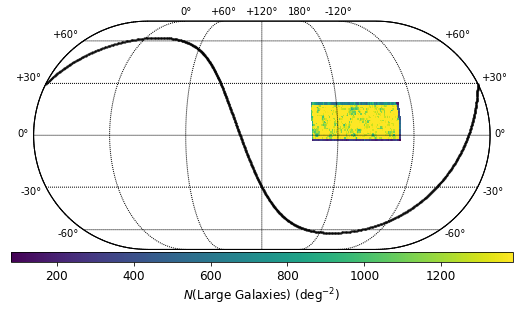

In [18]:
def qa_binned_radec(cat, nside=64, png=None):
    import warnings
    import healpy as hp
    import desimodel.io
    import desimodel.footprint
    from desiutil.plots import init_sky
    
    ra, dec = cat['RA'].data, cat['DEC'].data
    hpix = desimodel.footprint.radec2pix(nside, ra, dec)
    
    fig, ax = plt.subplots(figsize=(9, 5))

    with warnings.catch_warnings():
        pixweight = desimodel.io.load_pixweight(nside)
        fracarea = pixweight[hpix]
        weight = 1 / fracarea
        
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax,
                           ra_labels=[0,  60, 120, 180, 240, 300], 
                           dec_labels=[-60, -30,   0,  30,  60])
        grid_data, grid_data_prep = plot_sky_binned_2(ra, dec, weights=weight, 
                        max_bin_area=hp.nside2pixarea(nside, degrees=True),
                        verbose=True, clip_lo='!1', clip_hi='98%', cmap='viridis',
                        plot_type='grid', basemap=basemap, label=r'$N$(Large Galaxies) (deg$^{-2}$)')
    
    if png:
        fig.savefig(png, bbox_inches='tight', pad_inches=0)
    
    return grid_data, grid_data_prep
        
grid_data, grid_data_prep = qa_binned_radec(cat)

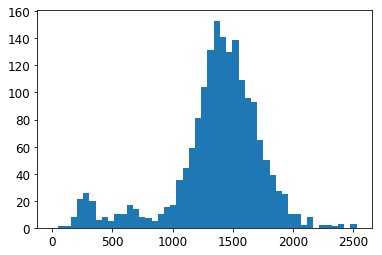

In [99]:
X = grid_data_prep[grid_data_prep >0]
bins = np.linspace(0, X.max(), 50)
plt.hist(X, bins=bins)
plt.show()

In [ ]:
# def get_edges(cat):
    
    import warnings
    import healpy as hp
    import desimodel.io
    #import desimodel.footprint
    from desiutil.plots import plot_grid_map
    
    # Calculate the bin edges in degrees.
    ra = np.fmod(cat['RA'], 360.)
    ra[ra >= 180.] -= 360.
    dec = cat['DEC']

    ra_edges = np.linspace(ra.min(), ra.max(), len(ra) + 1)
    dec_edges = np.degrees(np.arcsin(np.linspace(np.sin(np.pi*(dec.min())/180.), np.sin(np.pi*(dec.max())/180.), len(dec) + 1)))

    plot_grid_map(cat, ra_edges, dec_edges, cmap='viridis', colorbar=True, label=None, basemap=None)

In [38]:
cat_N = fitsio.read('caseC/cat.fits')

## RANDOMS

In [41]:
#ran = '/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/randoms-dr7.1-0.22.0-1.fits'
ran = 'caseC/random_1400.fits'
random = Table.read(ran)

Number Pixels 786432
Pixel area: 0.0524558528257
13792640 13792640 622
1405.76439988


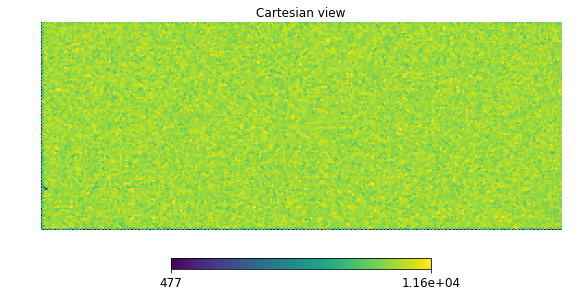

In [113]:
def pixmap(cat, N):
    #theta = 0.5 * np.pi - np.deg2rad(dec)
    #phi = np.deg2rad(ra)
    #N = 512
    ra = cat['RA']
    dec = cat['DEC']
    mask = ra > 180
    ra[mask] = ra[mask] - 360.
    mask = ra < -180
    ra[mask] = ra[mask] + 360.
    
    m = hp.ang2pix(N, ra, dec, nest=False, lonlat=True)

    def gen_fast_map(ip_, nside=N):
        npixel  = hp.nside2npix(nside)
        print('Number Pixels',npixel)
        #pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
        #print('Pixel area:', pix_area)
        map_ = np.bincount(ip_,minlength=npixel)
        return map_
    
    map = gen_fast_map(m)
    
    pix_area = hp.pixelfunc.nside2pixarea(N, degrees=True)
    print('Pixel area:', pix_area)
    print(map.sum(), len(ra), map.max())
    print(len(map[map>0])*pix_area)
    hp.cartview(map/pix_area, lonra=[-180, -130], latra=[-2,18])

pixmap(random, 256)

In [168]:
def n_density(cat, catR, A):
    
    g, r, z, w1, G, rr = get_mag_decals(cat)
    etaR = 13792640./A
    eta = []
    mag = np.linspace(15, 20, 100)
    Nran = len(catR)
    
    for i in range(len(mag)):
        
        N = len(cat[r < mag[i]])
        eta.append([mag[i], etaR*(N/Nran)])
            
    eta = np.array(eta).transpose()
    
    return eta

In [170]:
eta = n_density(catr, random, 1400)

In [178]:
mask_nobs = (random['NOBS_G'] > 0) & (random['NOBS_R'] > 0) & (random['NOBS_Z'] > 0)
eta_2 = n_density(cat, random[mask_nobs], 1400)

In [179]:
eta_LSLGA = n_density(cat[~LSLGA_mask_cat], random[(mask_nobs) & (~LSLGA_mask_ran)], 1400)

In [184]:
eta_twomass = n_density(cat[~twomass_mask_cat], random[(mask_nobs) & (~twomass_mask_ran)], 1400)

In [1]:
print(len(random[~twomass_mask_ran]), len(random)-np.sum(twomass_mask_ran))

NameError: name 'random' is not defined

In [181]:
def find_nearest(array, value):
    n = [abs(i-value) for i in array]
    idx = n.index(min(n))
    return idx

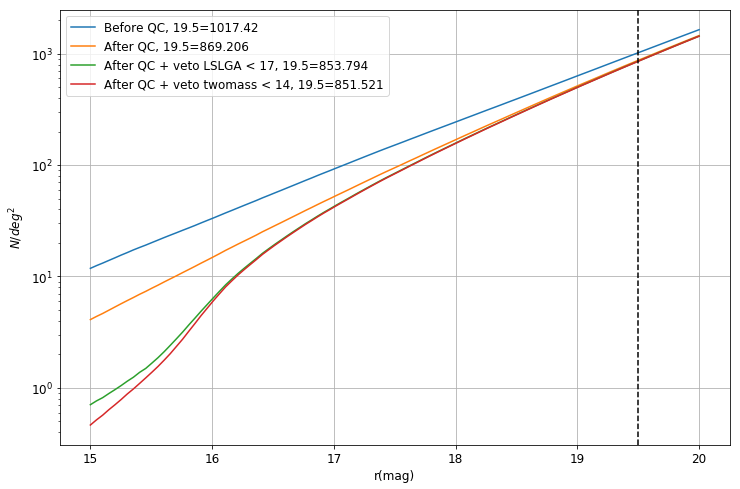

In [187]:
plt.figure(figsize=(12, 8))

plt.semilogy(eta[0], eta[1], label='Before QC, 19.5=%g' %(eta[1][find_nearest(eta[0], 19.5)]))
plt.semilogy(eta_2[0], eta_2[1], label='After QC, 19.5=%g' %(eta_2[1][find_nearest(eta_2[0], 19.5)]))

plt.semilogy(eta_LSLGA[0], eta_LSLGA[1], label='After QC + veto LSLGA < 17, 19.5=%g' %(eta_LSLGA[1][find_nearest(eta_LSLGA[0], 19.5)]))
plt.semilogy(eta_twomass[0], eta_twomass[1], label='After QC + veto twomass < 14, 19.5=%g' %(eta_twomass[1][find_nearest(eta_twomass[0], 19.5)]))

plt.xlabel(r'r(mag)')
plt.ylabel(r'$N/deg^2$')
plt.axvline(19.5, c='k', ls='--')
plt.legend()
plt.grid()
plt.show()

In [77]:
#random_S = cut(catr['RA'].min(), catr['RA'].max(), catr['DEC'].min(), catr['DEC'].max(), random)

In [78]:
#random_S.write('caseC/random_1400.fits', overwrite=True)

## 2D density plots

In [165]:
LSLGA

33.856293

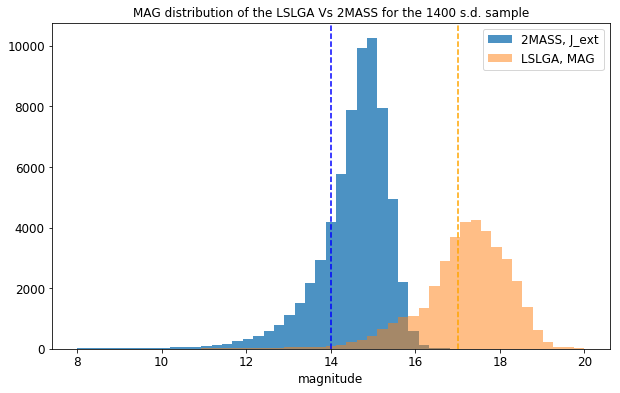

In [114]:
bins = np.linspace(8, 20, 50)
plt.figure(figsize=(10,6))
plt.hist(twomass_S['J_ext'], bins=bins, alpha=0.8, label=r'2MASS, J_ext')
plt.hist(LSLGA_S['MAG'], bins=bins, alpha=0.5, label=r'LSLGA, MAG')
plt.xlabel(r'magnitude')
plt.title(r'MAG distribution of the LSLGA Vs 2MASS for the 1400 s.d. sample')
plt.axvline(14, c='blue', ls='--')
plt.axvline(17, c='orange', ls='--')
plt.legend()
plt.show()

995414 nearby objects ~ 48.943 %


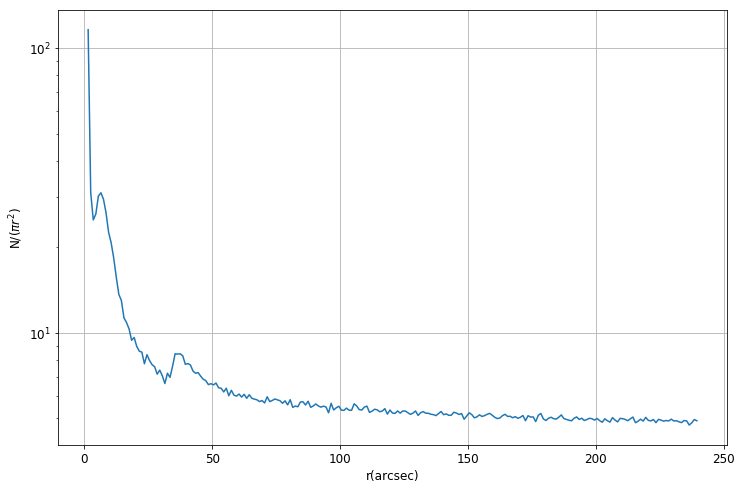

1176956 nearby objects ~ 51.0724 %


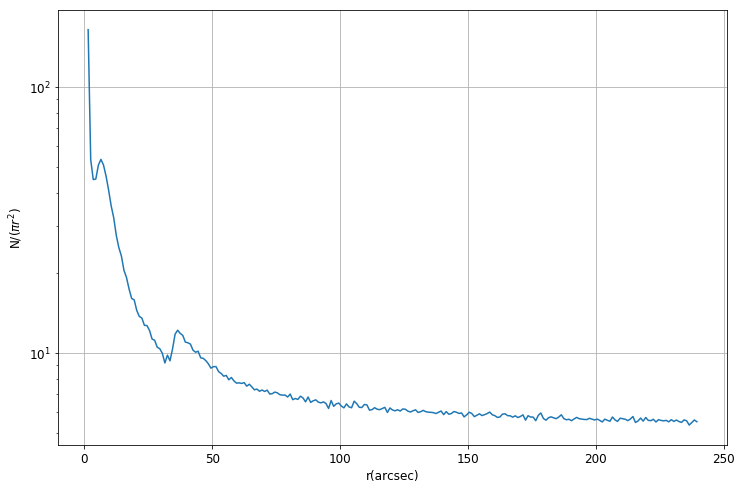

945712 nearby objects ~ 47.1069 %


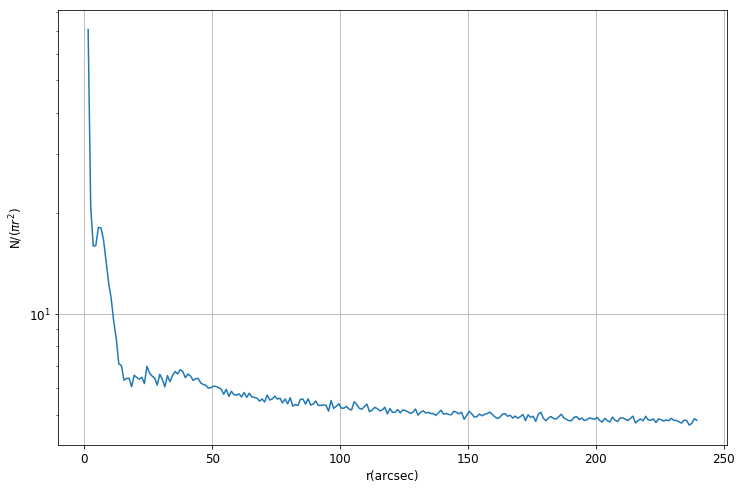

In [45]:
#den_twomass_cat = overdensity(cat, twomass_S, 'J_ext', 35, density=True, magbins=(8,16,5))
#den_twomass_catr = overdensity(catr, twomass_S, 'J_ext', 35, density=True, magbins=(8,16,5))
#den_twomass_cat_twomass = overdensity(cat[~twomass_mask_cat], twomass_S, 'J_ext', 35, density=True, magbins=(8,16,5))
den_LSLGA_cat = overdensity(cat, LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))
den_LSLGA_catr = overdensity(catr, LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))
den_LSLGA_cat_LSLGA = overdensity(cat[~LSLGA_mask_cat], LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))

5351097 nearby objects ~ 38.7968 %


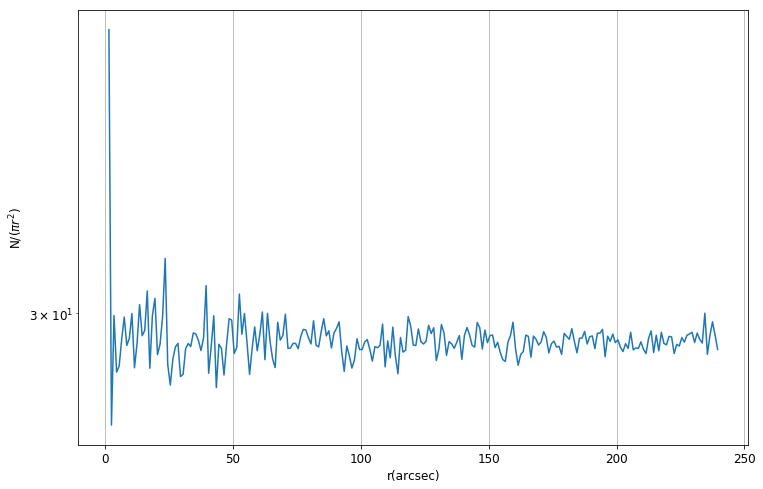

In [46]:
#den_twomass_ran = overdensity(random, twomass_S, 'J_ext', 35, density=True, magbins=(8,16,5))
den_LSLGA_ran = overdensity(random, LSLGA_S, 'J_ext', 35, density=True, magbins=(8,16,5))

4.546556540771277 5.375750190373051 5.658273343258836


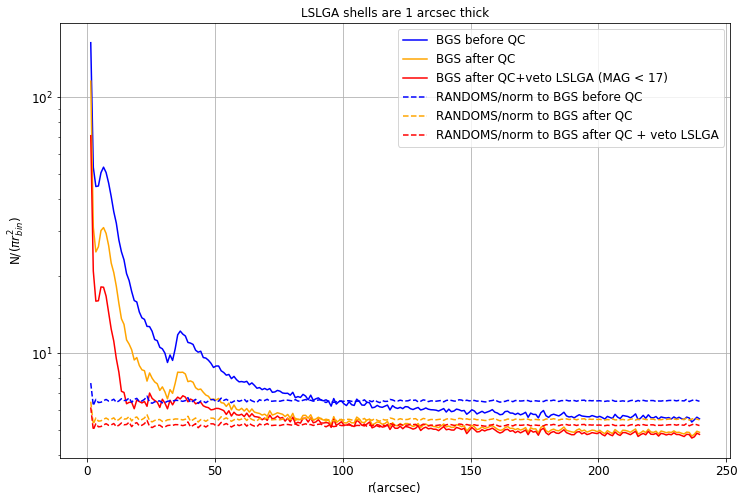

In [49]:
# Nearby to LSLGA Galaxies
del norm1, norm2, norm3
norm1 = 5351097/1176956 # Nrandom nearby/Ncatr nearby 
norm2 = 5351097/995414 # Nrandom nearby/Ncat nearby
norm3 = 5351097/945712 # Nrandom nearby/Ncat+veto LSLGA (MAG < 17) nearby
print(norm1, norm2, norm3)

plt.figure(figsize=(12, 8))
plt.semilogy(den_LSLGA_catr[0], den_LSLGA_catr[1], color='b', label='BGS before QC')
plt.semilogy(den_LSLGA_cat[0], den_LSLGA_cat[1], color='orange', label='BGS after QC')
plt.semilogy(den_LSLGA_cat_LSLGA[0], den_LSLGA_cat_LSLGA[1], color='red', label='BGS after QC+veto LSLGA (MAG < 17)')

plt.semilogy(den_LSLGA_ran[0], den_LSLGA_ran[1]/norm1, color='b', linestyle='--', label='RANDOMS/norm to BGS before QC')
plt.semilogy(den_LSLGA_ran[0], den_LSLGA_ran[1]/norm2, color='orange', linestyle='--', label='RANDOMS/norm to BGS after QC')
plt.semilogy(den_LSLGA_ran[0], den_LSLGA_ran[1]/norm3, color='red', linestyle='--', label='RANDOMS/norm to BGS after QC + veto LSLGA')
#plt.semilogy(test[0], test[1]/norm2, color='orange', linestyle='--', label='RANDOMS norm to BGS after')
plt.xlabel(r'r(arcsec)')
plt.ylabel(r'N/($\pi r_{bin}^2$)')
plt.title(r'LSLGA shells are 1 arcsec thick')
plt.legend()
plt.grid()
plt.show()

4.440112455937165 5.141122903056438 5.390759278056189


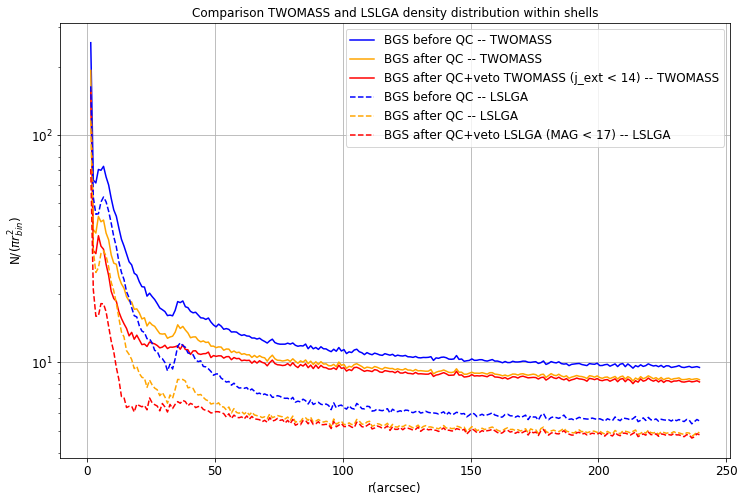

In [52]:
# Nearby to TWOMASS Galaxies
del norm1, norm2, norm3
norm1 = 8959512/2017857 # Nrandom nearby/Ncatr nearby 
norm2 = 8959512/1742715 # Nrandom nearby/Ncat nearby
norm3 = 8959512/1662013 # Nrandom nearby/Ncat+veto TWOMASS (j_ext < 14) nearby
print(norm1, norm2, norm3)

plt.figure(figsize=(12, 8))
plt.semilogy(den_twomass_catr[0], den_twomass_catr[1], color='b', label='BGS before QC -- TWOMASS')
plt.semilogy(den_twomass_cat[0], den_twomass_cat[1], color='orange', label='BGS after QC -- TWOMASS')
plt.semilogy(den_twomass_cat_twomass[0], den_twomass_cat_twomass[1], color='red', label='BGS after QC+veto TWOMASS (j_ext < 14) -- TWOMASS')

plt.semilogy(den_LSLGA_catr[0], den_LSLGA_catr[1], color='b', linestyle='--',label='BGS before QC -- LSLGA')
plt.semilogy(den_LSLGA_cat[0], den_LSLGA_cat[1], color='orange', linestyle='--', label='BGS after QC -- LSLGA')
plt.semilogy(den_LSLGA_cat_LSLGA[0], den_LSLGA_cat_LSLGA[1], color='red', linestyle='--', label='BGS after QC+veto LSLGA (MAG < 17) -- LSLGA')

#plt.semilogy(den_twomass_ran[0], den_twomass_ran[1]/norm1, color='b', linestyle='--', label='RANDOMS/norm to BGS before QC')
#plt.semilogy(den_twomass_ran[0], den_twomass_ran[1]/norm2, color='orange', linestyle='--', label='RANDOMS/norm to BGS after QC')
#plt.semilogy(den_twomass_ran[0], den_twomass_ran[1]/norm3, color='red', linestyle='--', label='RANDOMS/norm to BGS after QC + veto TWOMASS')

plt.xlabel(r'r(arcsec)')
plt.ylabel(r'N/($\pi r_{bin}^2$)')
plt.title(r'Comparison TWOMASS and LSLGA density distribution within shells')
plt.legend()
plt.grid()
plt.show()

## 2MASX VETO

In [20]:
def make_plot_zoom_comp(cat, BGAL1, BGAL2, veto1, veto2, ra, dec, m):  
    from matplotlib.patches import Ellipse

    RA1, DEC1, major1, minor1, angle1 = twomass_fit(BGAL1)
    l01 = BGAL1['Jpa']
    j_ext1 = BGAL1['J_ext']

    RA2, DEC2, major2, minor2, angle2 = LSLGA_fit(BGAL2)
    l02 = BGAL2['PA']
    j_ext2 = BGAL2['MAG']
    
    #vetoes in common
    x = cat['RA'][(veto1) & (veto2)]
    y = cat['DEC'][(veto1) & (veto2)]
    
    h1 = RA1
    z1 = DEC1
    
    h2 = RA2
    z2 = DEC2
    
    index1 = min(range(len(h1)), key=lambda i: abs(h1[i]-ra))
    index2 = min(range(len(h2)), key=lambda i: abs(h2[i]-ra))
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, marker='.', color='orange')
    plt.scatter(cat['RA'][(~veto1) & (~veto2)], cat['DEC'][(~veto1) & (~veto2)], marker='.', color='g')
    plt.scatter(cat['RA'][(~veto1) & (veto2)], cat['DEC'][(~veto1) & (veto2)], marker='.', color='blue')
    plt.scatter(cat['RA'][(veto1) & (~veto2)], cat['DEC'][(veto1) & (~veto2)], marker='.', color='blue')
    plt.scatter(h1, z1, marker='*', color='r')
    plt.scatter(h2, z2, marker='+', color='black')

    print('TWOMASS: RA = %2.5g, DEC = %2.5g, J_{ext}=%2.5g, angle = %d'%(h1[index1], z1[index1], 
                                                                          j_ext1[index1], l01[index1]))
    print('LSLGA: RA = %2.5g, DEC = %2.5g, MAG=%2.5g, angle = %d'%(h2[index2], z2[index2], 
                                                                    j_ext2[index2], l02[index2]))
    #print(title1)
    #print(title2)
    plt.xlim(ra-m*major1[index1], ra+m*major1[index1])
    plt.ylim(dec-m*major1[index1], dec+m*major1[index1])
    
    ax = plt.gca()
    ellipse1 = Ellipse((h1[index1], z1[index1]), width=2*major1[index1], height=2*minor1[index1], angle=angle1[index1], 
                       edgecolor='r', fc='None', lw=1)
    
    ellipse2 = Ellipse((h2[index2], z2[index2]), width=2*major2[index2], height=2*minor2[index2], angle=angle2[index2], 
                       edgecolor='r', fc='None', lw=1, ls='--')
    #ellipse3 = Ellipse((h[index], z[index]), width=2*a_best_fit[index], height=2*b_best_fit[index], angle=l[index], edgecolor='black', fc='None', lw=1)
    #ellipse2 = Ellipse((h[index], z[index]), width=2*a_r_fe[index], height=2*b_r_fe[index], angle=l[index], edgecolor='blue', fc='None', lw=1)

    ax.add_patch(ellipse1)
    ax.add_patch(ellipse2)
    #ax.add_patch(ellipse3)
    ax.legend([r'TWOMASS: $a =%2.4g\,(arcsec)$'%(major1[index1]*3600), r'LSLGA: $a =%2.4g\,(arcsec)$'%(major2[index2]*3600)], loc = 'upper right')
    ax.invert_xaxis()
    plt.show()

In [36]:
def mask_funct():
    
    x1, y1 = np.transpose([[9.5,100], [10.5, 80], [11.5, 70], [12.5, 50], [13.5, 30], [14.5, 20], [15.5, 10], [16.5, 5]])
    circular_mask_radii_func1 = interp1d(x1, y1, bounds_error=False, fill_value=(y1[0], y1[-1]))
    
    x2, y2 = np.transpose([[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]])
    circular_mask_radii_func2 = interp1d(x2, y2, bounds_error=False, fill_value=(y2[0], y2[-1]))
    
    plt.figure(figsize=(10,6))
    
    mag = np.linspace(5, 20, 30)
    
    plt.plot(mag, circular_mask_radii_func1(mag), marker='o', label=r'TWOMASS(J_ext)')
    plt.plot(mag, circular_mask_radii_func2(mag), marker='o', label=r'LSLGA(MAG)')
    plt.title(r'Mask radii')
    plt.legend()
    plt.grid()
    plt.xlabel(r'mag')
    plt.ylabel(r'r(arcsec)')
    plt.show()
    

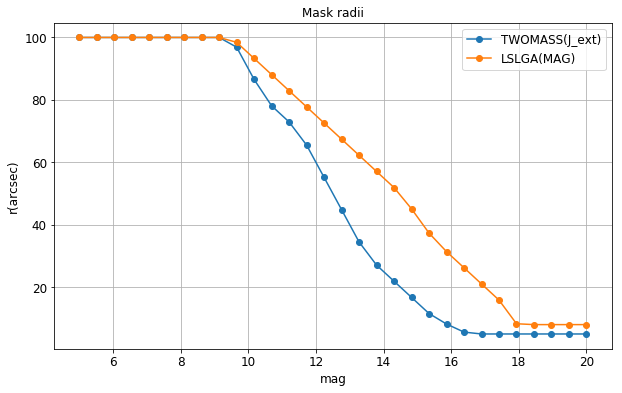

In [37]:
mask_funct()

In [21]:
def twomass_fit(twomass):
    
    x, y = np.transpose([[9.5,100], [10.5, 80], [11.5, 70], [12.5, 50], [13.5, 30], [14.5, 20], [15.5, 10], [16.5, 5]])
    circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))
    j_ext = np.array(twomass['J_ext'])
    major = circular_mask_radii_func(j_ext)/3600.#[degrees]
    minor = major*twomass['Jb_a']#[degrees]
    angle = -twomass['Jpa'] - 90.
    
    return twomass['RA'], twomass['DEC'], major, minor, angle

In [22]:
def LSLGA_fit(LSLGA):
    
    x, y = np.transpose([[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]])
    circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))
    MAG = np.array(LSLGA['MAG'])
    major = circular_mask_radii_func(MAG)/3600.#[degrees]
    minor = major*LSLGA['BA']#[degrees]
    angle = 90 - LSLGA['PA'] #-LSLGA['PA'] - 90.
    
    return LSLGA['RA'], LSLGA['DEC'], major, minor, angle

In [23]:
def twomass_veto(cat, twomass):
    
    RA, DEC, major, minor, angle = twomass_fit(twomass)
    centers = (RA, DEC)
    mask = veto_ellip((cat['RA'], cat['DEC']), centers, major, minor, angle)
    #dataset[vetoname][mask] = True
    
    return mask

In [24]:
def LSLGA_veto(cat, LSLGA):
    
    RA, DEC, major, minor, angle = LSLGA_fit(LSLGA)
    centers = (RA, DEC)
    mask = veto_ellip((cat['RA'], cat['DEC']), centers, major, minor, angle)
    #dataset[vetoname][mask] = True
    
    return mask

In [25]:
mask = twomass_S['J_ext'] < 14
#np.sum(mask)
twomass_mask_catr = twomass_veto(catr, twomass_S[mask])
twomass_mask_cat = twomass_veto(cat, twomass_S[mask])

In [26]:
mask2 = LSLGA_S['MAG'] < 17
#np.sum(mask2)
LSLGA_mask_catr = LSLGA_veto(catr, LSLGA_S[mask2])
LSLGA_mask_cat = LSLGA_veto(cat, LSLGA_S[mask2])

In [166]:
#mask_R = LSLGA_S['MAG'] < 17
#np.sum(mask2)
twomass_mask_ran = twomass_veto(random, twomass_S[mask])
LSLGA_mask_ran = LSLGA_veto(random, LSLGA_S[mask2])

In [177]:
twomass_mask_ran[:10]
#from astropy.io import ascii
#Table(twomass_mask_catr).write('caseC/twomass_mask_catr.fits', overwrite=True)
#twomass_mask_cat.write('caseC/twomass_mask_cat.fits', overwrite=True)

#LSLGA_mask_catr.write('caseC/LSLGA_mask_catr.fits', overwrite=True)
#LSLGA_mask_cat.write('caseC/LSLGA_mask_cat.fits', overwrite=True)

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [122]:
LSLGA_S[LSLGA_S['MAG'] < 12][:20]
#twomass_S[twomass_S['J_ext'] < 10][:15]
#print(len(cat), np.sum(twomass_mask_cat), np.sum(LSLGA_mask_cat))

<Table length=20>
LSLGA_ID  GALAXY  PGC       RA     ... IN_ALLWISE IN_DESI NEAR_BRIGHTSTAR
 int64    str29  int64   float64   ...    bool      bool        bool     
-------- ------- ----- ----------- ... ---------- ------- ---------------
    7880 NGC4321 40153 185.7286665 ...       True    True           False
   80824 NGC5850 53979 226.7819145 ...       True    True           False
   82623 NGC4365 40375 186.1169205 ...      False    True           False
  108597 NGC4298 39950 185.3867325 ...       True    True           False
  118815 NGC4552 41968 188.9160405 ...       True    True           False
  177774 NGC3412 32508 162.7220985 ...       True    True           False
  183687 NGC4374 40455   186.26544 ...       True    True           False
  192469 NGC4501 41517  187.997064 ...       True    True           False
  201338 NGC4450 41024 187.1229825 ...       True    True           False
  212827 NGC4486 41361  187.706364 ...       True    True           False
  217865 NGC4754 43656 193.0728855 ...       True    True           False
  259423 NGC5846 53932  226.621887 ...       True    True           False
  270550 NGC4350 40295  185.990895 ...       True    True           False
  274719 NGC3627 34695 170.0625345 ...       True    True           False
  278781 NGC4568 42069 189.1428405 ...       True    True           False
  296110 NGC4608 42545  190.305291 ...       True    True           False
  328560 NGC5713 52412 220.0479525 ...       True    True           False
  330560 NGC5838 53862  226.359564 ...       True    True           False
  350310 NGC5566 51233 215.0826915 ...       True    True           False
  351814 NGC4254 39578 184.7067315 ...       True    True           False

$\eta_{BQC} = N_{BQC}/A$

$\eta_{AQC} = N_{AQC}/NR_{NOBS}\times \eta_{Ran}$

$\eta_{AQC+TWOMASS} = N_{AQC+TWOMASS}/NR_{NOBS+TWOMASS}\times \eta_{Ran}$

$\eta_{AQC+LSLGA} = N_{AQC+LSLGA}/NR_{NOBS+LSLGA}\times \eta_{Ran}$

$\eta_{R} = NR/A = 13792640/1400$

TWOMASS: RA = 186.27, DEC = 12.887, J_{ext}=7.124, angle = -32
LSLGA: RA = 186.27, DEC = 12.887, MAG=10.011, angle = 133


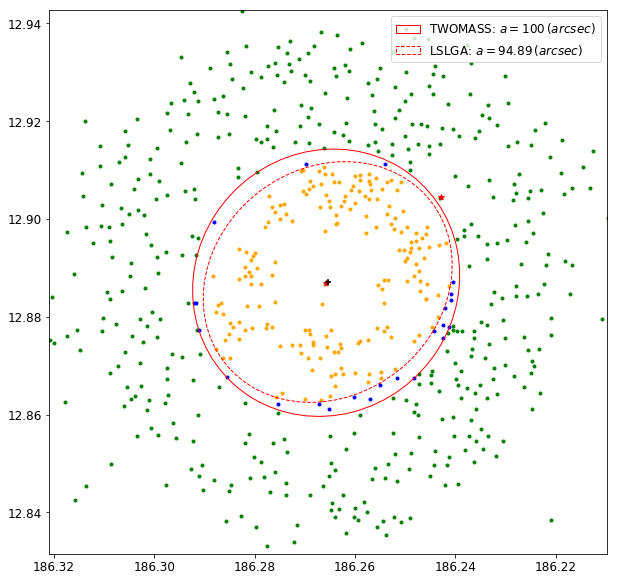

In [129]:
make_plot_zoom_comp(catr, twomass_S[mask], LSLGA_S[mask2], twomass_mask_catr, LSLGA_mask_catr, 186.26544, 12.8871094, 2)

TWOMASS: RA = 186.27, DEC = 12.887, J_{ext}=7.124, angle = -32
LSLGA: RA = 186.27, DEC = 12.887, MAG=10.011, angle = 133


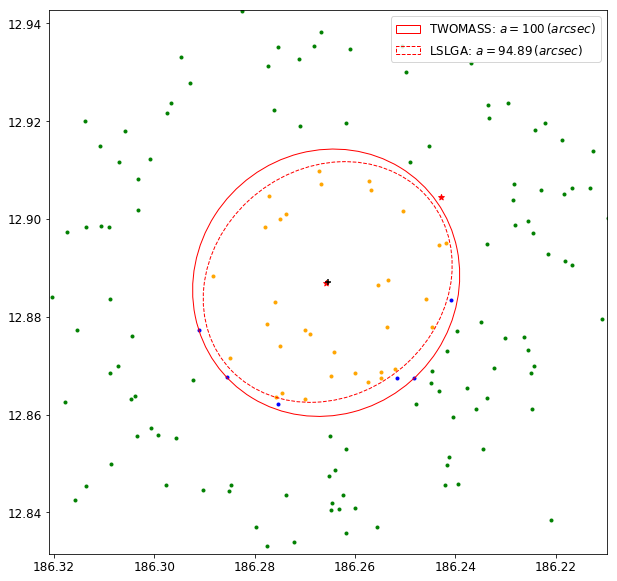

In [130]:
make_plot_zoom_comp(cat, twomass_S[mask], LSLGA_S[mask2], twomass_mask_cat, LSLGA_mask_cat, 186.26544, 12.8871094, 2)

pixels: 1527


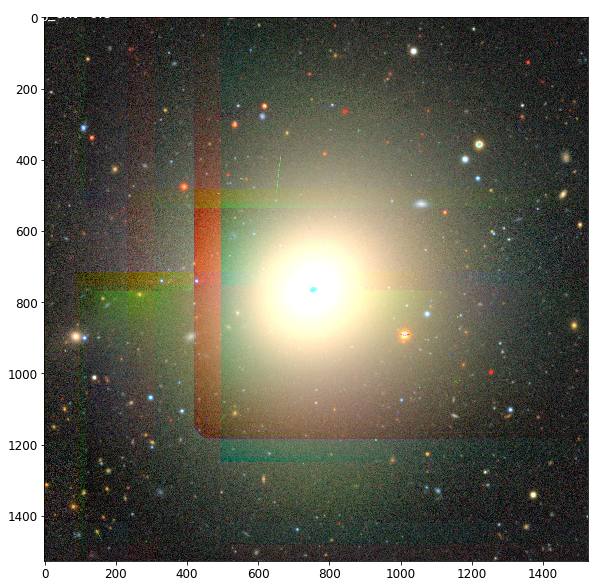

In [131]:
make_cutout_table(186.26544, 12.8871094, 6.83, 'J_ext', (1,1), False, boxsize=400, layer='decals-dr7', layer2=None)

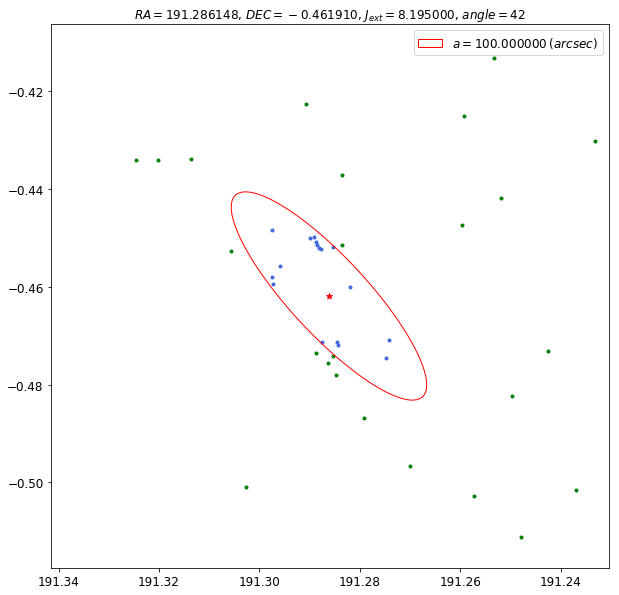

In [64]:
make_plot_zoom(cat, twomass_S[mask], twomass_mask_cat, 191.286, -0.46191, 2, True)

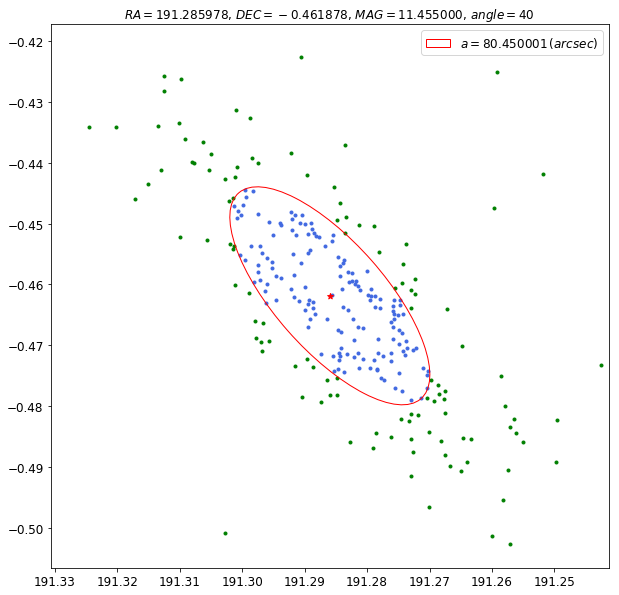

In [76]:
make_plot_zoom(catr, LSLGA_S[mask2], LSLGA_mask_catr, 191.286, -0.46191, 2, False)

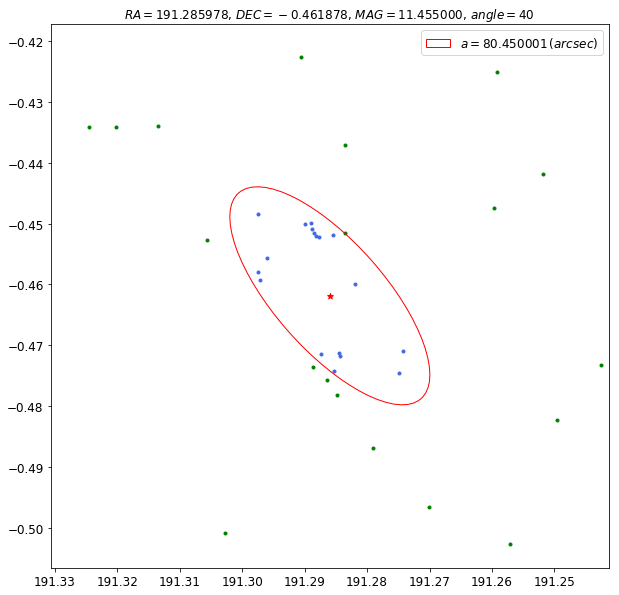

In [77]:
make_plot_zoom(cat, LSLGA_S[mask2], LSLGA_mask_cat, 191.286, -0.46191, 2, False)

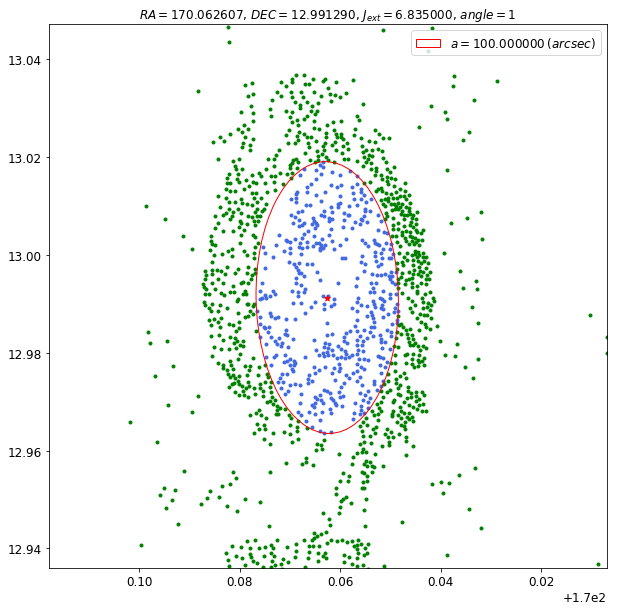

In [65]:
make_plot_zoom(catr, twomass_S[mask], twomass_mask_catr, 170.0625345, 12.9916041, 2, True)

## POSTAGE IMAGES

18238 nearby objects ~ 147.449 %
12714 sources ~19.6395 % 
Inside shell: 5788


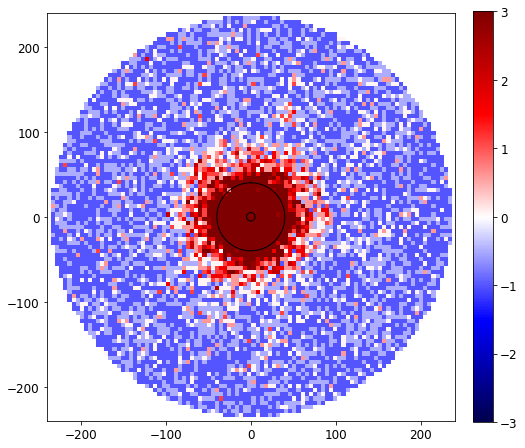

In [109]:
#a,b,c = extract_annulus(cat[~LSLGA_mask_cat], LSLGA_S, 'MAG', plot2d='square', mag=(12,15), annulus=(35,45))
#a,b,c = extract_annulus(cat[~twomass_mask_cat], twomass_S, 'J_ext', plot2d='circle', mag=(0,10), annulus=(35,80))
a,b,c = extract_annulus(cat[(twomass_mask_cat) & (~LSLGA_mask_cat)], twomass_S, 'J_ext', plot2d='circle', mag=(0,14), annulus=(5,40))
#a,b,c = extract_annulus(cat[(~twomass_mask_cat) & (LSLGA_mask_cat)], LSLGA_S, 'MAG', plot2d='circle', mag=(0,17), annulus=(5,30))

In [56]:
def make_cutout_table(ra_in, dec_in, other=None, othername=None, table=(2,7), compare=False, 
                      scale_unit='pixscale', boxsize=30, scale=0.262, layer='decals-dr7', layer2=None, savefile=None):
    """
    Produces a table comparing LEGACY survey images.
    To see the different layers see: https://github.com/yymao/decals-image-list-tool/blob/master/index.html
    
    Keyword arguments:
    ra_in            -- array-like: RA positions in degrees 
    dec_in           -- array-like: DEC positions in degrees 
    other            -- array-like: any other parameter, e.g. magnitude
    othername        -- string: name or label of the 'other' parameter
    table            -- 2D integer array: arrange of the output images in (rows * columns) form
    compare          -- boolean: True if want to get output images comparing with other layer (currently in test mode)
    scale_unit       -- striing: pixel scale default
    scale            -- float: 1:180 arcsec
    layer            -- string: type of layer from legacysurvey. e.g:
                            ls-dr67:Legacy Survey DR6+7
                            decals-dr7:DECaLS DR7
                            decals-dr7-model:DECaLS DR7 Model
                            decals-dr7-resid:DECaLS DR7 Residual
                            mzls+bass-dr6:MzLS+BASS DR6
                            mzls+bass-dr6-model:MzLS+BASS DR6 Model
                            mzls+bass-dr6-resid:MzLS+BASS DR6 Residual
    layer2            -- string: second layer to compare if 'compare=True'
    savefile          -- string: path of output image and pdf if any
    """    
    de_img = []
    wi_img = []
    N = table[0]*table[1]
    size = int(round(boxsize/scale))
    print('pixels:',size)
    
    if isinstance(ra_in, float):
        de_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%g&dec=%g&%s=%g&layer=%s&size=%g' % (ra_in,dec_in, scale_unit, scale, layer, size)
        img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
        
        fig = plt.figure(figsize=(10,10))
        plt.imshow(img)
        if other != None:
            plt.text(0.1,0.9,'%s=%.1f'%(othername,other),fontsize=14,color='white')
        
        return
        
    
    for i in range(N):
        de_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%g&dec=%g&%s=%g&layer=%s&size=%g' % (ra_in[i],dec_in[i], scale_unit, scale, layer, size)
        img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
        de_img.append(img)
        
        if compare:
            wi_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%g&dec=%g&%s=%g&layer=%s&size=%g' % (ra_in[i],dec_in[i], scale_unit, scale, layer2, size)
            img = plt.imread(download_file(wi_cutout_url,cache=True,show_progress=False,timeout=120))
            wi_img.append(img)
            
    fig = plt.figure(figsize=(4*table[1],4*table[0]))

    for i in range(len(de_img)):
        ax = fig.add_subplot(table[0],table[1],i+1)
        ax.imshow(de_img[i])
        #ax.xaxis.set_major_formatter(NullFormatter())
        #ax.yaxis.set_major_formatter(NullFormatter())
        if other[i] != None:
            ax.text(0.1,0.9,'%s=%.1f'%(othername,other[i]),transform=ax.transAxes,fontsize=14,color='white')

    plt.subplots_adjust(wspace=0.07, hspace=0.07)
    
    if compare:
        fig = plt.figure(figsize=(4*table[1],4*table[0]))
        for i in range(len(wi_img)):
            ax = fig.add_subplot(table[0],table[1],i+1)
            ax.imshow(wi_img[i])
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())
            if other[i] != None:
                ax.text(0.1,0.9,'%s=%.1f'%(othername,other[i]),transform=ax.transAxes,fontsize=14,color='white')

        plt.subplots_adjust(wspace=0.07, hspace=0.07)
    
    if savefile != None:
        fig.savefig(savefile +'.png')
        fig.savefig(savefile +'.pdf')

In [60]:
print(len(cat[LSLGA_mask_cat]))

26235


18238 nearby objects ~ 147.449 %
12714 sources ~19.6395 % 
Inside shell: 4178


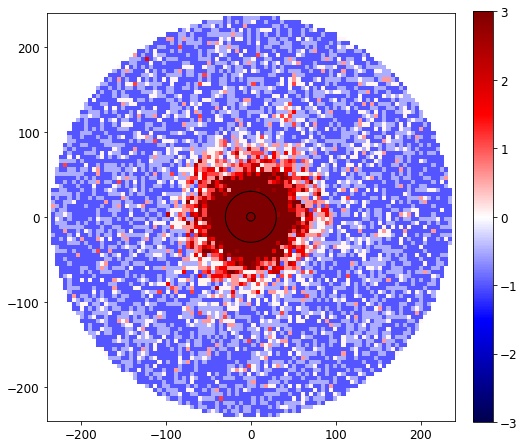

pixels: 76
pixels: 76


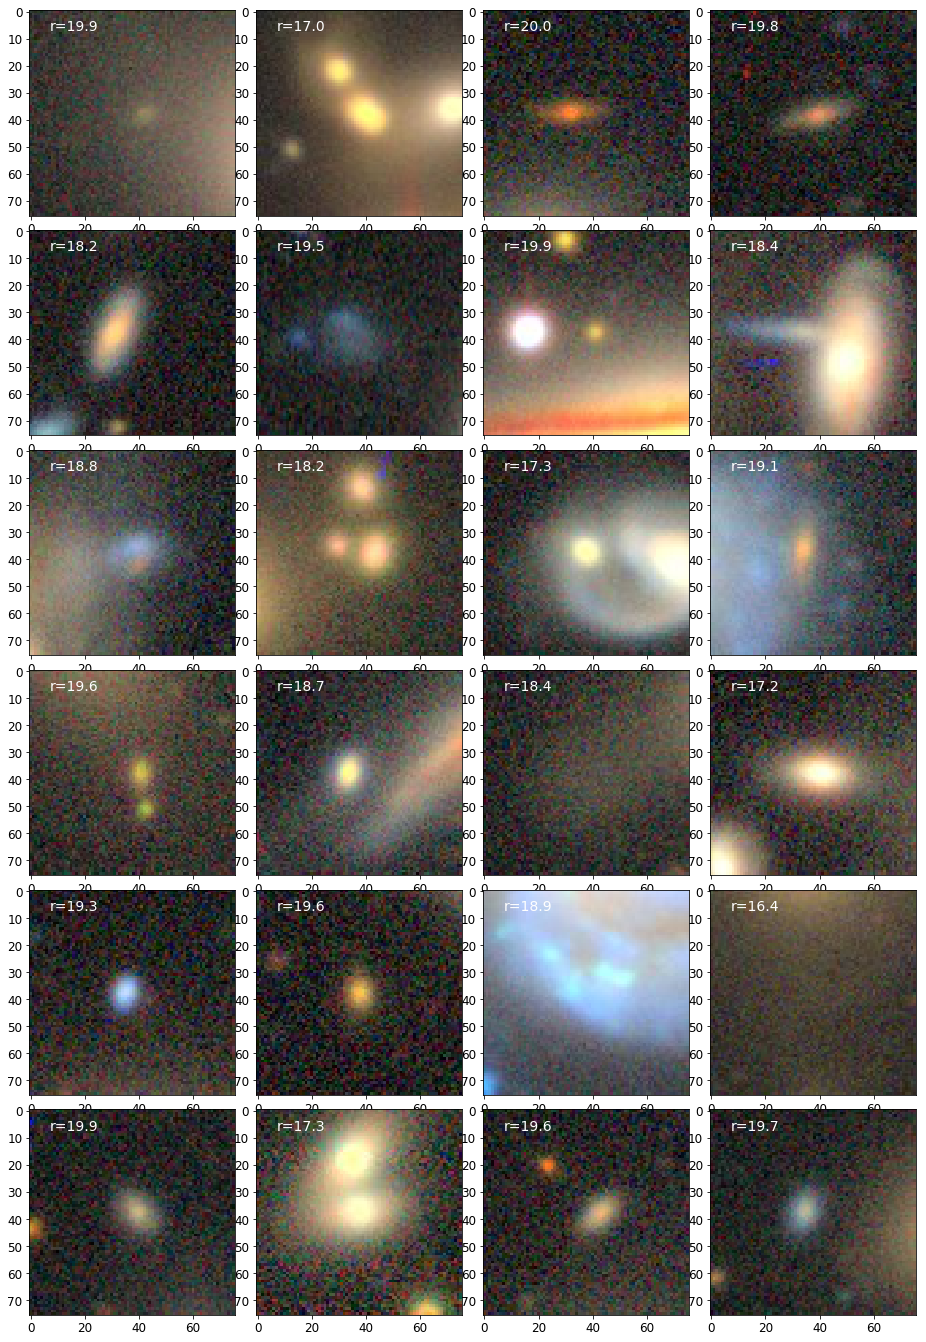

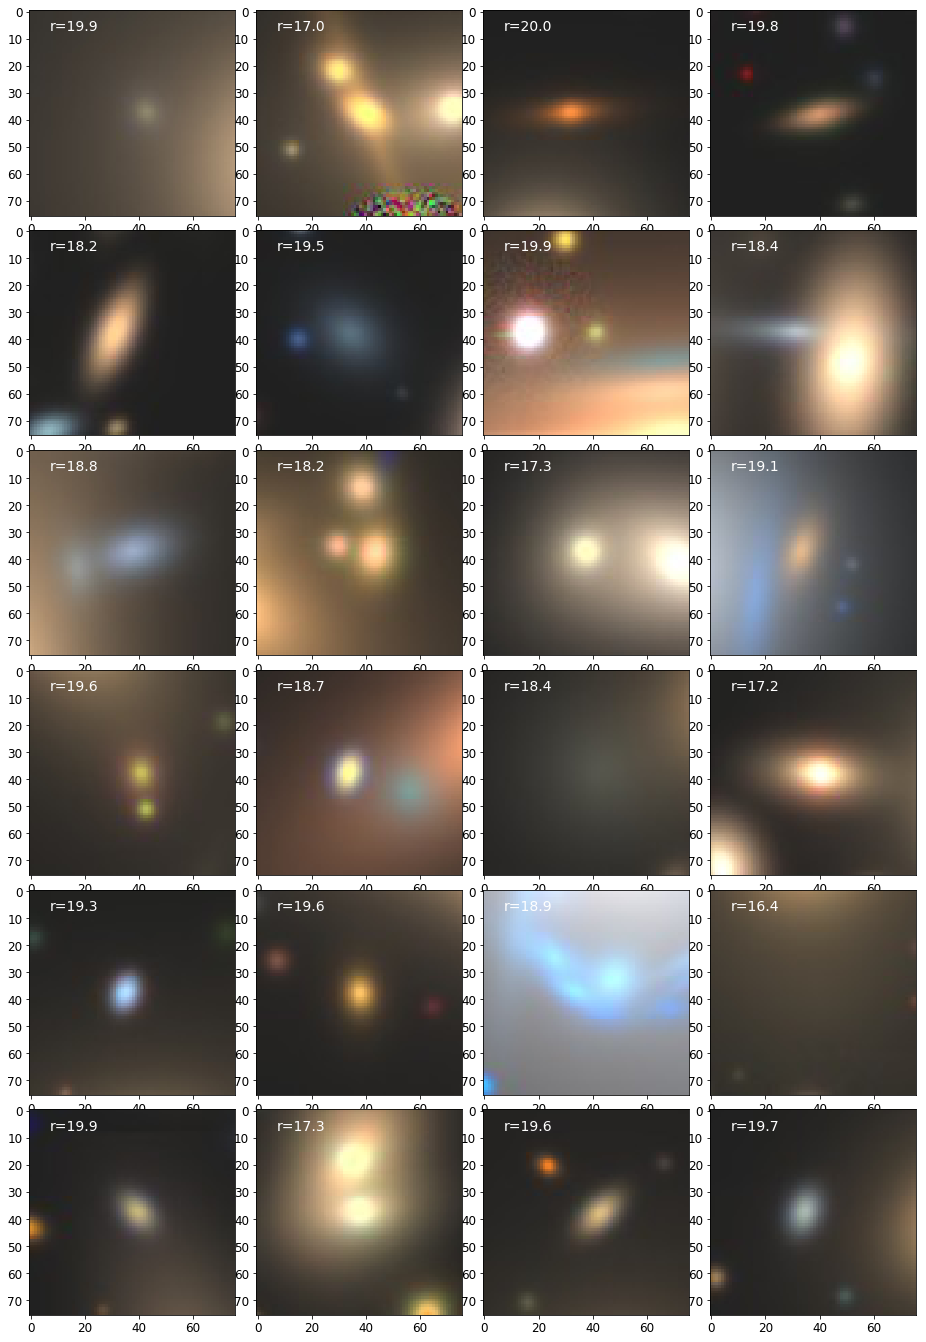

In [112]:
import random
n = 6   #rows
m = 4   #columns
table = (n,m)
#RA, DEC, r = extract_annulus(cat[~twomass_mask_cat], twomass_S, 'J_ext', plot2d='circle', mag=(0,10), annulus=(35,80))
RA, DEC, r = extract_annulus(cat[(twomass_mask_cat) & (~LSLGA_mask_cat)], twomass_S, 'J_ext', plot2d='circle', mag=(0,14), annulus=(5,30))
ranSelect = random.sample(range(len(RA)), n*m)

make_cutout_table(RA[ranSelect], DEC[ranSelect], r[ranSelect], 'r', table, False, boxsize=20, 
                  layer='decals-dr7', layer2=None, savefile='caseC/sample_LSLGA_out_TWOMASS_in')

make_cutout_table(RA[ranSelect], DEC[ranSelect], r[ranSelect], 'r', table, False, boxsize=20, 
                  layer='decals-dr7-model', layer2=None, savefile='caseC/sample_LSLGA_out_TWOMASS_in_models')
#make_cutout_table(191.286, -0.46191, 8.1, 'MAG', table, False, boxsize=400, layer='decals-dr7', layer2=None)

TWOMASS: RA = 191.29, DEC = -0.46191, J_{ext}=8.195, angle = 42
LSLGA: RA = 191.29, DEC = -0.46188, MAG=11.455, angle = 40


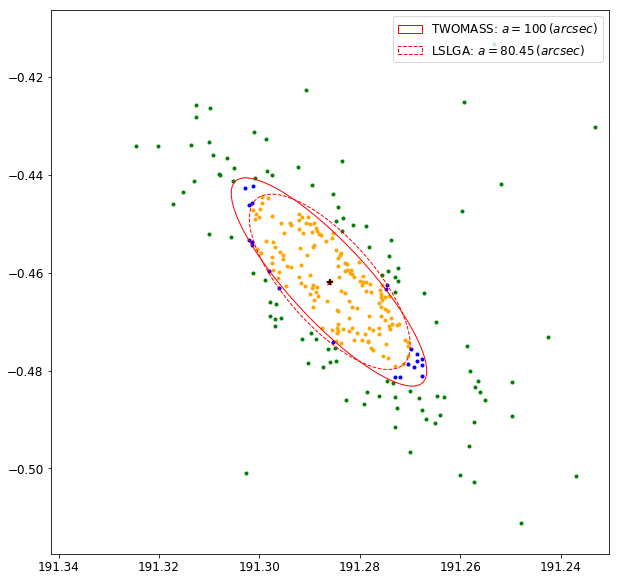

In [131]:
make_plot_zoom_comp(catr, twomass_S[mask], LSLGA_S[mask2], twomass_mask_catr, LSLGA_mask_catr, 191.286, -0.46191, 2)

## DEV ZONE

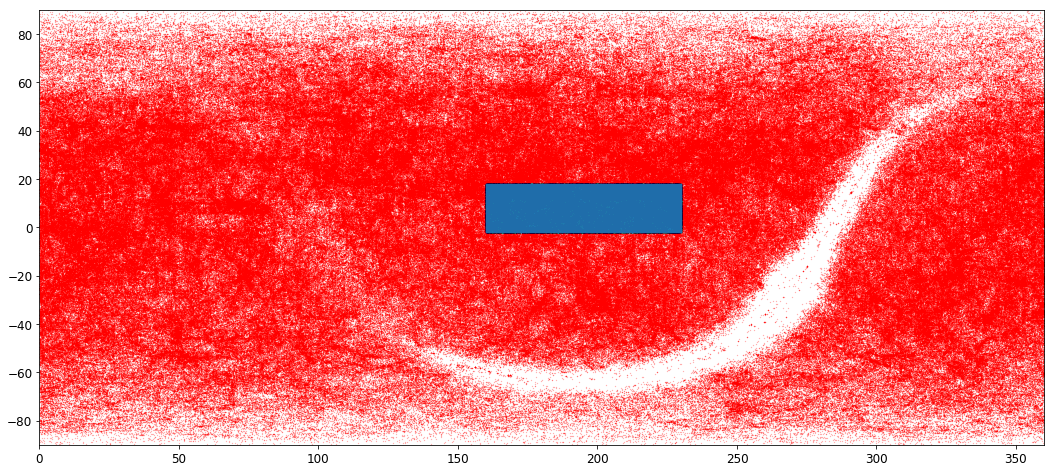

In [5]:
plt.figure(figsize=(18, 8))
plt.plot(twomass['RA'], twomass['DEC'], '.', color='red', markersize=0.5, alpha=0.5)
plt.plot(catr['RA'], catr['DEC'], '.', markersize=0.4, alpha=0.2)
#plt.plot(tycho['RA'], tycho['DEC'], '.', markersize=0.3, alpha=0.2)
plt.axis([0, 360, -90, 90])
#plt.axis([200, 230, -2, 5])
plt.show()

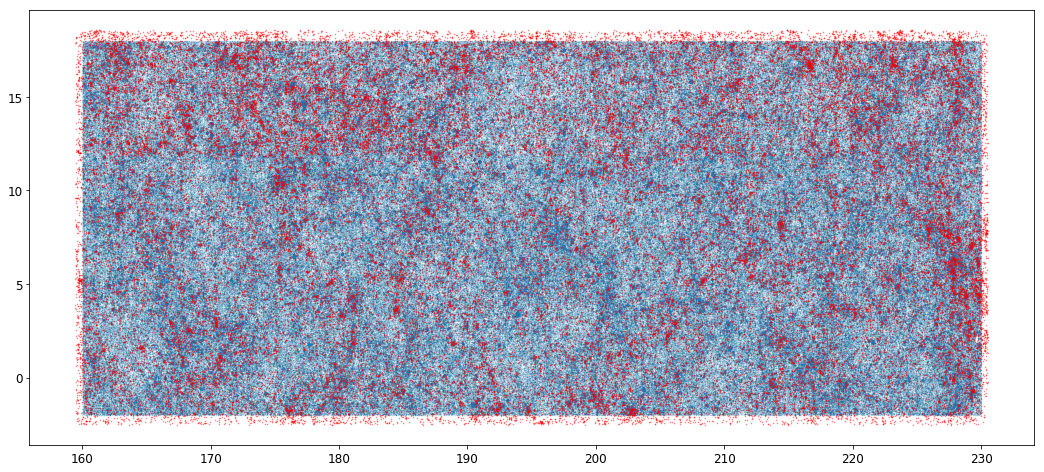

In [9]:
plt.figure(figsize=(18, 8))
plt.plot(catr['RA'], catr['DEC'], '.', markersize=0.4, alpha=0.2)
plt.plot(twomass_S['RA'], twomass_S['DEC'], '.', color='red', markersize=1, alpha=0.5)
#plt.plot(tycho['RA'], tycho['DEC'], '.', markersize=0.3, alpha=0.2)
#plt.axis([0, 360, -90, 90])
#plt.axis([200, 230, -2, 5])
plt.show()

#overdensity(cat, twomass_S, 'J_ext', magbins=(6,16,11))

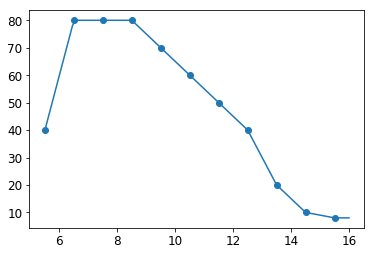

In [14]:
x, y = np.transpose([[5.5,40], [6.5, 80], [7.5, 80], [8.5, 80], [9.5, 70], [10.5, 60], [11.5, 50], [12.5, 40], [13.5, 20], [14.5, 10], [15.5, 8]])
circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))
X = np.linspace(5.5, 16, 100)
plt.scatter(x, y)
plt.plot(X, circular_mask_radii_func(X))

5.985126401288617 6.781639092132494


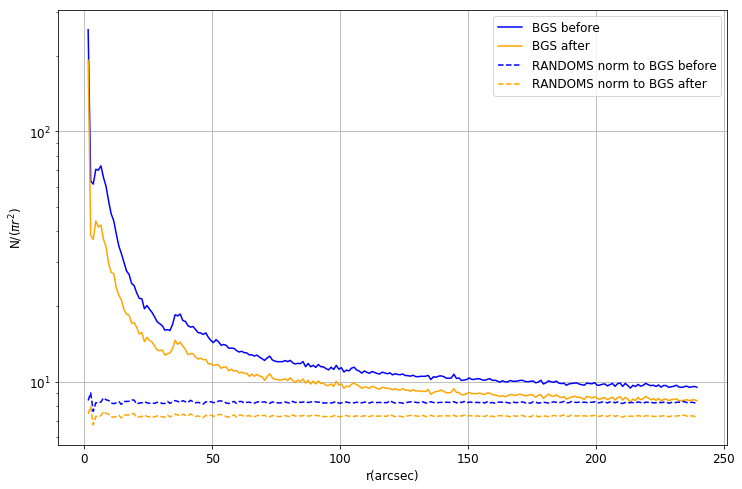

In [210]:
norm1 = len(random_S)/len(catr)
norm2 = len(random_S)/len(cat)
print(norm1, norm2)

plt.figure(figsize=(12, 8))
plt.semilogy(density_catr[0], density_catr[1], color='b', label='BGS before')
plt.semilogy(density_cat[0], density_cat[1], color='orange', label='BGS after')
plt.semilogy(test[0], test[1]/norm1, color='b', linestyle='--', label='RANDOMS norm to BGS before')
plt.semilogy(test[0], test[1]/norm2, color='orange', linestyle='--', label='RANDOMS norm to BGS after')
plt.xlabel(r'r(arcsec)')
plt.ylabel(r'N/($\pi r^2$)')
plt.legend()
plt.grid()
plt.show()

In [36]:
#extract subcatalogue and save it
del cat_lite

cat_lite = Table()
lite_names = ('RA', 'DEC', 'TYPE', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FLUX_W1','MW_TRANSMISSION_R',
              'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'GAIA_PHOT_G_MEAN_MAG', 'Grr', 
              'BRIGHTSTARINBLOB')
for i in lite_names:
    
    cat_lite[i] = catr[i]
    
cat_lite.write('caseC/catr_lite.fits', overwrite=True)